In [20]:
"""
A jax implementation of the diffusion model from 
the paper "Improved Techniques for Training Score-Based Generative Models"
https://arxiv.org/abs/2006.09011
Code taken primarily from https://github.com/yang-song/score_sde/
Modifications by Matt Sampson include:
    - Minor updates to use the latest version of flax
    - changed optim.Adam to optax.adam (required for latex flax)
"""

%matplotlib inline
import functools
import math
import string
from typing import Any, Sequence, Optional
import flax.linen as nn
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.nn.initializers as init
import matplotlib as mpl
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import flax
import optax
Path("outputs").mkdir(exist_ok=True)

In [21]:
"""Common layers for defining score networks.
"""
class InstanceNorm2dPlus(nn.Module):
  """InstanceNorm++ as proposed in the original NCSN paper."""
  bias: bool = True

  @staticmethod
  def scale_init(key, shape, dtype=jnp.float32):
    normal_init = init.normal(0.02)
    return normal_init(key, shape, dtype=dtype) + 1.

  @nn.compact
  def __call__(self, x):
    means = jnp.mean(x, axis=(1, 2))
    m = jnp.mean(means, axis=-1, keepdims=True)
    v = jnp.var(means, axis=-1, keepdims=True)
    means_plus = (means - m) / jnp.sqrt(v + 1e-5)

    h = (x - means[:, None, None, :]) / jnp.sqrt(jnp.var(x, axis=(1, 2), keepdims=True) + 1e-5)

    h = h + means_plus[:, None, None, :] * self.param('alpha', InstanceNorm2dPlus.scale_init, (1, 1, 1, x.shape[-1]))
    h = h * self.param('gamma', InstanceNorm2dPlus.scale_init, (1, 1, 1, x.shape[-1]))
    if self.bias:
      h = h + self.param('beta', init.zeros, (1, 1, 1, x.shape[-1]))

    return h


def ncsn_conv1x1(x, out_planes, stride=1, bias=True, dilation=1, init_scale=1.):
  """1x1 convolution with PyTorch initialization. Same as NCSNv1/v2."""
  init_scale = 1e-10 if init_scale == 0 else init_scale
  kernel_init = jnn.initializers.variance_scaling(1 / 3 * init_scale, 'fan_in',
                                                  'uniform')
  kernel_shape = (1, 1) + (x.shape[-1], out_planes)
  bias_init = lambda key, shape: kernel_init(key, kernel_shape)[0, 0, 0, :]
  output = nn.Conv(out_planes, kernel_size=(1, 1),
                   strides=(stride, stride), padding='SAME', use_bias=bias,
                   kernel_dilation=(dilation, dilation),
                   kernel_init=kernel_init,
                   bias_init=bias_init)(x)
  return output

def ncsn_conv3x3(x, out_planes, stride=1, bias=True, dilation=1, init_scale=1.):
  """3x3 convolution with PyTorch initialization. Same as NCSNv1/NCSNv2."""
  kernel_init = jnn.initializers.variance_scaling(1 / 3 * init_scale, 'fan_in',
                                                  'uniform')
  kernel_shape = (3, 3) + (x.shape[-1], out_planes)
  #bias_init = lambda key, shape: kernel_init(key, kernel_shape)[0, 0, 0, :]
  bias_init = jnn.initializers.zeros
  output = nn.Conv(out_planes,
                   kernel_size=(3, 3),
                   strides=(stride, stride),
                   padding='SAME',
                   use_bias= bias,
                   kernel_dilation=(dilation, dilation),
                   kernel_init=kernel_init,
                   bias_init=bias_init)(x)
  return output

# ---------------------------------------------------------------- #
# Functions below are ported over from the NCSNv1/NCSNv2 codebase: #
# https://github.com/ermongroup/ncsn                               #
# https://github.com/ermongroup/ncsnv2                             #
# ---------------------------------------------------------------- #

class CRPBlock(nn.Module):
  """CRPBlock for RefineNet. Used in NCSNv2."""
  features: int
  n_stages: int
  act: Any = nn.relu

  @nn.compact
  def __call__(self, x):
    x = self.act(x)
    path = x
    for _ in range(self.n_stages):
      path = nn.max_pool(
        path, window_shape=(5, 5), strides=(1, 1), padding='SAME')
      path = ncsn_conv3x3(path, self.features, stride=1, bias=False)
      x = path + x
    return x


class RCUBlock(nn.Module):
  """RCUBlock for RefineNet. Used in NCSNv2."""
  features: int
  n_blocks: int
  n_stages: int
  act: Any = nn.relu

  @nn.compact
  def __call__(self, x):
    for _ in range(self.n_blocks):
      residual = x
      for _ in range(self.n_stages):
        x = self.act(x)
        x = ncsn_conv3x3(x, self.features, stride=1, bias=False)
      x = x + residual

    return x

class MSFBlock(nn.Module):
  """MSFBlock for RefineNet. Used in NCSNv2."""
  shape: Sequence[int]
  features: int
  interpolation: str = 'bilinear'

  @nn.compact
  def __call__(self, xs):
    sums = jnp.zeros((xs[0].shape[0], *self.shape, self.features))
    for i in range(len(xs)):
      h = ncsn_conv3x3(xs[i], self.features, stride=1, bias=True)
      if self.interpolation == 'bilinear':
        h = jax.image.resize(h, (h.shape[0], *self.shape, h.shape[-1]), 'bilinear')
      elif self.interpolation == 'nearest_neighbor':
        h = jax.image.resize(h, (h.shape[0], *self.shape, h.shape[-1]), 'nearest')
      else:
        raise ValueError(f'Interpolation {self.interpolation} does not exist!')
      sums = sums + h
    return sums

class RefineBlock(nn.Module):
  """RefineBlock for building NCSNv2 RefineNet."""
  output_shape: Sequence[int]
  features: int
  act: Any = nn.relu
  interpolation: str = 'bilinear'
  start: bool = False
  end: bool = False

  @nn.compact
  def __call__(self, xs):
    rcu_block = functools.partial(RCUBlock, n_blocks=2, n_stages=2, act=self.act)
    rcu_block_output = functools.partial(RCUBlock,
                                        features=self.features,
                                        n_blocks=3 if self.end else 1,
                                        n_stages=2,
                                        act=self.act)
    hs = []
    for i in range(len(xs)):
      h = rcu_block(features=xs[i].shape[-1])(xs[i])
      hs.append(h)

    if not self.start:
      msf = functools.partial(MSFBlock, features=self.features, interpolation=self.interpolation)
      h = msf(shape=self.output_shape)(hs)
    else:
      h = hs[0]

    crp = functools.partial(CRPBlock, features=self.features, n_stages=2, act=self.act)
    h = crp()(h)
    h = rcu_block_output()(h)
    return h

class ConvMeanPool(nn.Module):
  """ConvMeanPool for building the ResNet backbone."""
  output_dim: int
  kernel_size: int = 3
  biases: bool = True

  @nn.compact
  def __call__(self, inputs):
    output = nn.Conv(features=self.output_dim,
                    kernel_size=(self.kernel_size, self.kernel_size),
                    strides=(1, 1),
                    padding='SAME',
                    use_bias=self.biases)(inputs)
    output = sum([
      output[:, ::2, ::2, :], output[:, 1::2, ::2, :],
      output[:, ::2, 1::2, :], output[:, 1::2, 1::2, :]
    ]) / 4.
    return output


class MeanPoolConv(nn.Module):
  """MeanPoolConv for building the ResNet backbone."""
  output_dim: int
  kernel_size: int = 3
  biases: bool = True

  @nn.compact
  def __call__(self, inputs):
    output = inputs
    output = sum([
      output[:, ::2, ::2, :], output[:, 1::2, ::2, :],
      output[:, ::2, 1::2, :], output[:, 1::2, 1::2, :]
    ]) / 4.
    output = nn.Conv(
      features=self.output_dim,
      kernel_size=(self.kernel_size, self.kernel_size),
      strides=(1, 1),
      padding='SAME',
      use_bias=self.biases)(output)
    return output


class ResidualBlock(nn.Module):
  """The residual block for defining the ResNet backbone. Used in NCSNv2."""
  output_dim: int
  normalization: Any
  resample: Optional[str] = None
  act: Any = nn.elu
  dilation: int = 1

  @nn.compact
  def __call__(self, x):
    h = self.normalization()(x)
    h = self.act(h)
    if self.resample == 'down':
      h = ncsn_conv3x3(h, h.shape[-1], dilation=self.dilation)
      h = self.normalization()(h)
      h = self.act(h)
      if self.dilation > 1:
        h = ncsn_conv3x3(h, self.output_dim, dilation=self.dilation)
        shortcut = ncsn_conv3x3(x, self.output_dim, dilation=self.dilation)
      else:
        h = ConvMeanPool(output_dim=self.output_dim)(h)
        shortcut = ConvMeanPool(output_dim=self.output_dim, kernel_size=1)(x)
    elif self.resample is None:
      if self.dilation > 1:
        if self.output_dim == x.shape[-1]:
          shortcut = x
        else:
          shortcut = ncsn_conv3x3(x, self.output_dim, dilation=self.dilation)
        h = ncsn_conv3x3(h, self.output_dim, dilation=self.dilation)
        h = self.normalization()(h)
        h = self.act(h)
        h = ncsn_conv3x3(h, self.output_dim, dilation=self.dilation)
      else:
        if self.output_dim == x.shape[-1]:
          shortcut = x
        else:
          shortcut = ncsn_conv1x1(x, self.output_dim)
        h = ncsn_conv3x3(h, self.output_dim)
        h = self.normalization()(h)
        h = self.act(h)
        h = ncsn_conv3x3(h, self.output_dim)

    return h + shortcut

class ConditionalResidualBlock(nn.Module):
  """The noise-conditional residual block for building NCSNv1."""
  output_dim: int
  normalization: Any
  resample: Optional[str] = None
  act: Any = nn.elu
  dilation: int = 1

  @nn.compact
  def __call__(self, x, y):
    h = self.normalization()(x, y)
    h = self.act(h)
    if self.resample == 'down':
      h = ncsn_conv3x3(h, h.shape[-1], dilation=self.dilation)
      h = self.normalization(h, y)
      h = self.act(h)
      if self.dilation > 1:
        h = ncsn_conv3x3(h, self.output_dim, dilation=self.dilation)
        shortcut = ncsn_conv3x3(x, self.output_dim, dilation=self.dilation)
      else:
        h = ConvMeanPool(output_dim=self.output_dim)(h)
        shortcut = ConvMeanPool(output_dim=self.output_dim, kernel_size=1)(x)
    elif self.resample is None:
      if self.dilation > 1:
        if self.output_dim == x.shape[-1]:
          shortcut = x
        else:
          shortcut = ncsn_conv3x3(x, self.output_dim, dilation=self.dilation)
        h = ncsn_conv3x3(h, self.output_dim, dilation=self.dilation)
        h = self.normalization()(h, y)
        h = self.act(h)
        h = ncsn_conv3x3(h, self.output_dim, dilation=self.dilation)
      else:
        if self.output_dim == x.shape[-1]:
          shortcut = x
        else:
          shortcut = ncsn_conv1x1(x, self.output_dim)
        h = ncsn_conv3x3(h, self.output_dim)
        h = self.normalization()(h, y)
        h = self.act(h)
        h = ncsn_conv3x3(h, self.output_dim)

    return h + shortcut

In [22]:
""" 
MATT:
Want to build a U-NET in jax which will have 5 layers (to match Song+2020)
Need to take into acount the noise scales - ie embedding the noise scale into the model
Build this with flax.linen (flax.linen as nn)?
"""
# grabbed from https://github.com/yang-song/score_sde/blob/main/models/ncsnv2.py

CondResidualBlock = ConditionalResidualBlock
conv3x3 = ncsn_conv3x3

class NCSNv2(nn.Module):
  """NCSNv2 model architecture"""
  #config: ml_collections.ConfigDict

  @nn.compact
  #def __call__(self, x, labels, train=True):
  def __call__(self, x, labels):
    
    # hard coding configs for now
    sigma_begin   = 1                     # noise scale max
    sigma_end     = 1e-2                  # noise scale min
    num_scales    = 10                     # number of noise scales
    sigmas        = jnp.exp(jnp.linspace(jnp.log(sigma_end), 
                              jnp.log(sigma_begin),num_scales))
    im_size       = 32                    # image size
    nf            = 128                   # number of filters
    act           = nn.elu                # activation function
    normalizer    = InstanceNorm2dPlus    # normalization function
    interpolation = 'bilinear'            # interpolation method for upsample
    
    # data already centered
    h = x
    
    # Begin the U-Net
    h = conv3x3(h, nf, stride=1, bias=True)

    # ResNet backbone
    h = ResidualBlock(nf, resample=None, act=act, normalization=normalizer)(h)
    layer1 = ResidualBlock(nf, resample=None, act=act, normalization=normalizer)(h)
    h = ResidualBlock(2 * nf, resample='down', act=act, normalization=normalizer)(layer1)
    layer2 = ResidualBlock(2 * nf, resample=None, act=act, normalization=normalizer)(h)
    h = ResidualBlock(2 * nf,
                      resample='down',
                      act=act,
                      normalization=normalizer,
                      dilation=2)(layer2)
    layer3 = ResidualBlock(2 * nf, resample=None, act=act, normalization=normalizer, dilation=2)(h)
    h = ResidualBlock(2 * nf,
                      resample='down',
                      act=act,
                      normalization=normalizer,
                      dilation=4)(layer3)
    layer4 = ResidualBlock(2 * nf, resample=None, act=act, normalization=normalizer, dilation=4)(h)
    # U-Net with RefineBlocks
    ref1 = RefineBlock(layer4.shape[1:3],
                       2 * nf,
                      act=act,
                      interpolation=interpolation,
                      start=True)([layer4])
    ref2 = RefineBlock(layer3.shape[1:3],
                       2 * nf,
                      interpolation=interpolation,
                      act=act)([layer3, ref1])
    ref3 = RefineBlock(layer2.shape[1:3],
                       2 * nf,
                      interpolation=interpolation,
                      act=act)([layer2, ref2])
    ref4 = RefineBlock(layer1.shape[1:3],
                      nf,
                      interpolation=interpolation,
                      act=act,
                      end=True)([layer1, ref3])

    h = normalizer()(ref4)
    h = act(h)
    h = conv3x3(h, x.shape[-1])

    # normlising the output
    used_sigmas = sigmas[labels].reshape(
        (x.shape[0], *([1] * len(x.shape[1:]))))
    
    return h / used_sigmas




In [23]:
"""
The loss function for a noise dependent score model from Song+2020
"""
def anneal_dsm_score_estimation(params, model, samples, labels, sigmas, key):
    """
    Loss function for annealed score estimation
    -------------------------------------------
    Inputs: model - the score neural network
            samples - the samples from the data distribution
            labels - the noise scale labels
            sigmas - the noise scales
            key - the jax random key
            variables - the model parameters
    
    Output: the loss value
    """
    used_sigmas = sigmas[labels].reshape((samples.shape[0], *([1] * len(samples.shape[1:]))))
    noise = jax.random.normal(key, samples.shape)
    perturbed_samples = samples + noise * used_sigmas
    target = -noise / used_sigmas**2
    scores = model.apply({'params': params}, perturbed_samples, labels)
    #losses = jnp.square(score - target)
    loss_1 = 1 / 2. * ((scores - target) ** 2).sum(axis=-1) #* used_sigmas.squeeze() ** anneal_power
    loss = loss_1 * used_sigmas**2 
    loss = jnp.mean(loss)
    return loss

In [24]:
""" 
The training of the NCSNv2 model. Here define the training
parameters and initialise the model. Train on a small scale 
for testing before moving to the full scale on GPU HPC.
"""
# ----------- #
# model setup #
# ----------- #

# load in data  low res
"""
box_size = 31
dataname = 'sources_box' + str(box_size) + '.npy'     
dataset = np.load(dataname)

# perform zero-padding of the data to get desired dimensions
data_padded_31 = []
for i in range(len(dataset)):
    data_padded_tmp = np.pad(dataset[i], ((0,1),(0,1)), 'constant')
    data_padded_31.append(data_padded_tmp)
dataset = np.array( data_padded_31 )
"""

# load in data  high res
box_size = 61
dataname = 'sources_box' + str(box_size) + '.npy'     
dataset = np.load(dataname)

# perform zero-padding of the data to get desired dimensions
data_padded_61 = []
for i in range(len(dataset)):
    data_padded_tmp = np.pad(dataset[i], ((1,2),(1,2)), 'constant')
    data_padded_61.append(data_padded_tmp)
dataset = np.array( data_padded_61 )

# convert dataset to jax array
data_jax = jnp.array(dataset)
# expand dimensions for channel dim
data_jax = jax.numpy.expand_dims(data_jax, axis=-1)

# define noise levels 
sigma_begin = 1
sigma_end   = 0.01
num_scales  = 10
sigmas      = jnp.exp(jnp.linspace(jnp.log(sigma_end), 
                        jnp.log(sigma_begin),num_scales))

# score model params
n_epochs    = 50                                    # number of epochs
steps       = 1_000                                 # number of steps per epoch
batch_size  = 32                                    # batch size
lr          = 1e-4                                  # learning rate
rng         = jax.random.PRNGKey(1992)              # random seed
input_shape = (jax.local_device_count(), 32, 32, 1) # size 32 by 32 one channel
label_shape = input_shape[:1]
fake_input  = jnp.zeros(input_shape)
fake_label  = jnp.zeros(label_shape, dtype=jnp.int32)
params_rng, dropout_rng = jax.random.split(rng)
model = NCSNv2()
variables = model.init({'params': params_rng}, fake_input, fake_label)
init_model_state, initial_params = variables.pop('params')

In [25]:
# ------------------------------ #
# visualisation for code testing #
# ------------------------------ #
import cmasher as cmr
score_map = cmr.iceburn
data_map = cmr.ember
def plot_evolve(params,sample,step, labels):
    gaussian_noise = jax.random.normal(rng, shape=sample.shape)
    scores = model.apply({'params' : params}, gaussian_noise, labels)
    scores2 = model.apply({'params' : params}, sample, labels)
    fig , ax = plt.subplots(2,2,figsize=(16, 12), facecolor='white',dpi = 70)
    plt.subplots_adjust(wspace=0.01)
    plt.subplot(2,2,1)
    plt.imshow(scores[0], cmap=score_map)
    #plt.colorbar()
    plt.title('Gaussian Noise',fontsize=36,pad=15)
    plt.ylabel('score', fontsize=40)
    plt.subplot(2,2,2)
    plt.imshow(scores2[0], cmap=score_map)
    cbar = plt.colorbar()
    cbar.set_label(r'$\nabla_x log \ p(\mathbf{\tilde{x}})$', rotation=270, fontsize = 20,labelpad= 25)
    plt.title('Galaxy',fontsize=36,pad=15)
    plt.subplot(2,2,3)
    plt.imshow(gaussian_noise[0], cmap=data_map)
    plt.ylabel('data', fontsize=40)
    plt.subplot(2,2,4)
    plt.imshow(sample[0], cmap=data_map)
    cbar = plt.colorbar()
    cbar.set_label(r'pixel density', rotation=270, fontsize = 20,labelpad= 25)
    super_name = 'training step ' + str(step) 
    plt.suptitle(super_name, fontsize = 40)
    plt.tight_layout()
    save_name = 'score_estimation_pre_training_step_' + str(step) + '.png'
    plt.savefig(save_name,facecolor='white',dpi=300)

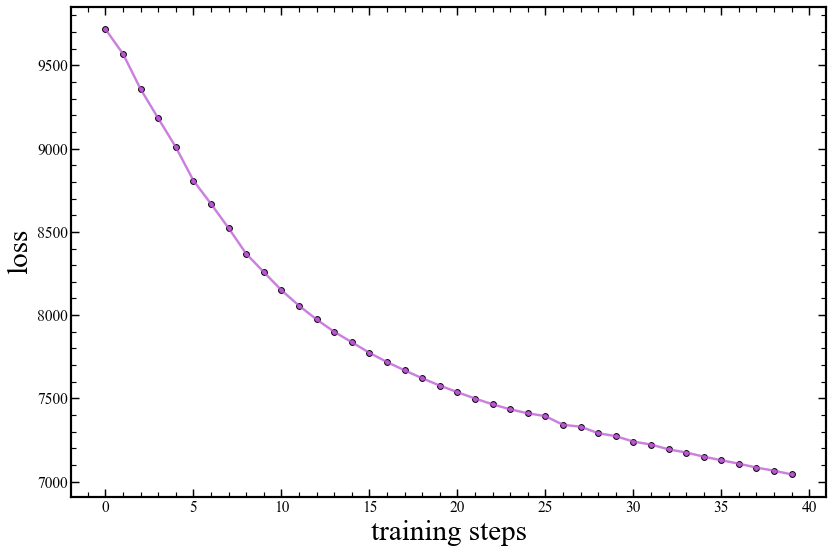

In [29]:
# optax testing bench
# re-create random key and noise labels for testing
key_seq = jax.random.PRNGKey(0)
samples = data_jax[key_seq]
sigmas      = jnp.exp(jnp.linspace(jnp.log(sigma_end), 
                        jnp.log(sigma_begin),num_scales))
labels = jax.random.randint(key_seq, (len(data_jax[key_seq]),), minval=0, maxval=len(sigmas), dtype=jnp.int32)

# define optimiser using latest flax standards
optimizer = optax.adam(learning_rate=lr, 
                       b1=0.9, 
                       b2=0.999, 
                       eps=1e-08, 
                       eps_root=0.0, 
                       mu_dtype=None) 

# initialise model state
params = initial_params
model_state = optimizer.init(params)

# name loss function
loss_fn = anneal_dsm_score_estimation

# A simple update loop
train = False
step_num = 40
if train:
  loss_vector = np.zeros(step_num)
  for i in range(step_num):
    grads = jax.grad(loss_fn)(params, model, samples, labels, sigmas, key_seq)
    updates, model_state = optimizer.update(grads, model_state)
    params = optax.apply_updates(params, updates)
    loss_vector[i] = loss_fn(params, model, samples, labels, sigmas, key_seq)
    print(f'loss at step {i}: {loss_vector[i]}')
    # make plot so see evolution
    plot_evolve(params, samples, i, labels)
  

fig , ax = plt.subplots(1,1,figsize=(12, 8), facecolor='white',dpi = 70)
steps = range(0,step_num)
plt.plot(steps,loss_vector, alpha = 0.75, zorder = 0)
plt.scatter(steps,loss_vector, zorder = 1)
plt.xlabel('training steps', fontsize = 30)
plt.ylabel('loss', fontsize = 30)
plt.tight_layout()
plt.savefig('loss_evolution.png',facecolor='white',dpi=300)

In [27]:
# ------------------------- #
# langevin dynamic sampling #
# ------------------------- #
# TODO: port to jax

def anneal_Langevin_dynamics(x_mod, scorenet, sigmas, n_steps_each=100, step_lr=0.000008,
                             final_only=False, verbose=False, denoise=True):
    images = []
    scores  = []

    for c, sigma in enumerate(sigmas):
        labels = torch.ones(x_mod.shape[0], device=x_mod.device) * c
        labels = labels.long()
        step_size = step_lr * (sigma / sigmas[-1]) ** 2
        step_size_cpu = step_size.to('cpu') 
        for s in range(n_steps_each):
            grad = scorenet(x_mod, labels)
            scores.append(grad.to('cpu'))
            noise = torch.randn_like(x_mod)
            grad_norm = torch.norm(grad.view(grad.shape[0], -1), dim=-1).mean()
            noise_norm = torch.norm(noise.view(noise.shape[0], -1), dim=-1).mean()
            x_mod = x_mod + step_size_cpu * grad + noise * np.sqrt(step_size_cpu * 2)

            if not final_only:
                images.append(x_mod.to('cpu'))

    if denoise:
        last_noise = (len(sigmas) - 1) * torch.ones(x_mod.shape[0], device=x_mod.device)
        last_noise = last_noise.long()
        x_mod = x_mod + sigmas[-1] ** 2 * scorenet(x_mod, last_noise)
        images.append(x_mod.to('cpu'))

    return images, scores